# Analysis — Cookie Cats A/B Test


## Summary

### 🎯 Goal
Evaluate whether the new game version (treatment) leads to higher player engagement, measured by the number of game rounds played.

### 📊 Metric Choice
- Primary metric: Number of game rounds played.
- Rationale: It directly reflects engagement and is a more meaningful measure than 1-day or 7-day retention alone.
- Retention metrics are kept as guardrails (safety checks), not primary outcomes.

### 🧪 Statistical Test
- Test used: Independent two-sample t-test (comparing treatment vs control).
- Confidence level: 95% (α = 0.05).
- Data transformation: Since game rounds are exponentially distributed (long right tail), a log transformation was applied to approximate normality and meet t-test assumptions.

### 📈 Results
- p-value: 0.07
- Decision: Fail to reject the null hypothesis (since 0.07 > 0.05).
- Interpretation: There is no statistically significant difference in the average (logged) number of game rounds played between the control and treatment groups.
- Confidence interval: Includes 0, consistent with the non-significant result.

### 🧠 Conclusion
The new version did not significantly change player engagement in terms of game rounds played.
Retention metrics can still be reviewed as guardrails, but based on the t-test outcome, the experiment provides no evidence of a performance improvement from the treatment version.

In [8]:
import pandas as pd
import seaborn as sns
import statsmodels.stats.api as sms

from scipy import stats
from scipy.stats import norm

from math import sqrt

In [9]:
df_raw = pd.read_csv('cookie_cats.csv',index_col=False)

In [10]:
df_raw.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


Data Definitions
- `userid`: A unique number that identifies each player.
- `version`: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
- `sum_gamerounds`: the number of game rounds played by the player during the first 14 days after install.
- `retention_1`: Did the player come back and play 1 day after installing?
- `retention_7`: Did the player come back and play 7 days after installing?

In [11]:
df = df_raw.copy()

### Data Preparation

In [12]:
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [13]:
for col in [c for c in df.columns if c not in ['userid','sum_gamerounds']]:
    print(f"\nColumn: {col}")
    print(df_raw[col].value_counts())


Column: version
version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

Column: retention_1
retention_1
False    50036
True     40153
Name: count, dtype: int64

Column: retention_7
retention_7
False    73408
True     16781
Name: count, dtype: int64


### 🚨 Do we have a sample/ratio mismatch? 🚨

An SRM means something’s wrong with randomisation or data collection, such as:
- Tracking or logging errors
- Biased assignment (e.g., by device or geography)
- Users being bucketed inconsistently (e.g., cookies, caching, bot traffic)

If we get something off from 50% split this could be a red flag. In this case we have a 50.2% vs 49.8% split. What is the probability this could have happened by chance?

Let's check...



In [15]:
control = len(df[df['version'] == 'gate_30'])
treatment = len(df[df['version'] == 'gate_40'])
n = control + treatment

expected_ratio = 0.5
control_ratio = control / n
z_score = abs((control_ratio - expected_ratio) / sqrt( expected_ratio * (1- expected_ratio) / (n)))

p_norm_two_sided = 2 * norm.sf(z_score)

print(round(p_norm_two_sided,4))


0.0086


If the p-value is very low (we use <0.001), then you likely have a sample-ratio mismatch and the experiment results are not trustworthy

✅ In this case our p-value is 0.0086 which is greater than 0.001 which means it's unlikely we've run into a Sample Ratio mismatch

<Axes: xlabel='version', ylabel='sum_gamerounds'>

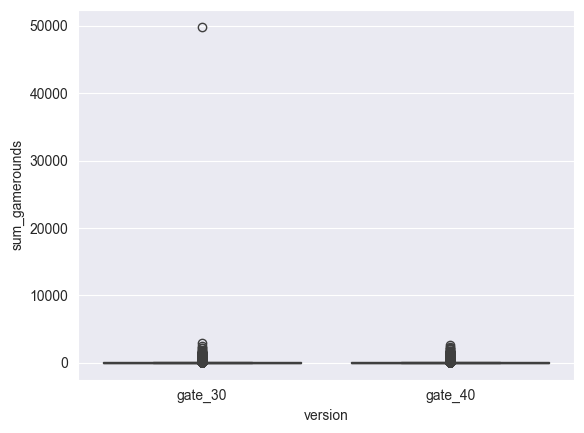

In [16]:
sns.boxplot(data=df, x='version', y='sum_gamerounds')

In [17]:
df.sort_values(by=['sum_gamerounds'], ascending=False).head(5)

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False
43671,4832608,gate_30,2438,True,True
48188,5346171,gate_40,2294,True,True


It looks like we have a pretty wild outlier, user 6390605 has played over 16 times more gamnerounds that the next highest user. We'll exclude this user as this seems highly unlikely to be organicaly driven and even if that were the case the instance is so extreme it could skew our data.

In [18]:
df.loc[57702]

userid            6390605
version           gate_30
sum_gamerounds      49854
retention_1         False
retention_7          True
Name: 57702, dtype: object

In [19]:
df = df.drop(57702)

In [20]:
df.sort_values(by=['sum_gamerounds'], ascending=False).head(5)

,userid,version,sum_gamerounds,retention_1,retention_7
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False
43671,4832608,gate_30,2438,True,True
48188,5346171,gate_40,2294,True,True
46344,5133952,gate_30,2251,True,True


In [21]:
df['sum_gamerounds'].quantile(0.9)

np.float64(134.0)

<Axes: xlabel='sum_gamerounds', ylabel='Count'>

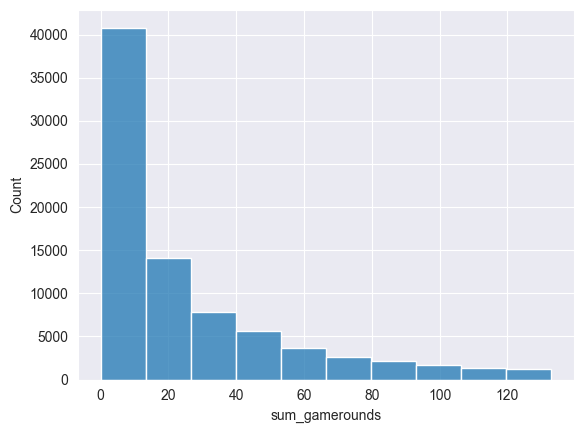

In [22]:
sns.histplot(data=df[(df['sum_gamerounds'] < df['sum_gamerounds'].quantile(0.9))],x='sum_gamerounds', bins=10)

<Axes: xlabel='sum_gamerounds', ylabel='Density'>

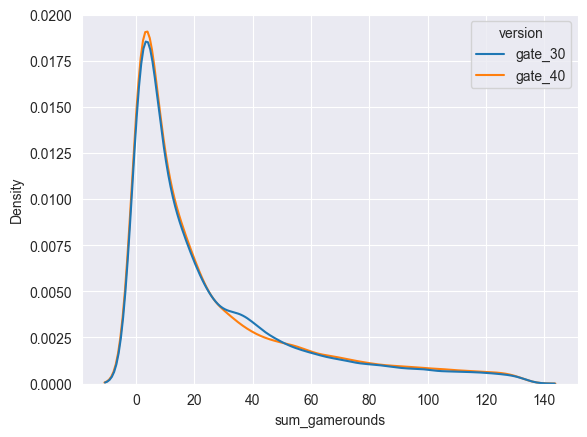

In [23]:
sns.kdeplot(data=df[(df['sum_gamerounds'] < df['sum_gamerounds'].quantile(0.9))],x='sum_gamerounds',hue='version')

In [24]:
df_grouped = (
    df.groupby(["version", "retention_1"])
      .agg(count=("version", "size"), avg_gamerounds=("sum_gamerounds", "mean"))
)

df_grouped["avg_gamerounds"] = df_grouped["avg_gamerounds"].round(2)
df_grouped

count  avg_gamerounds
version retention_1                       
gate_30 False        24665           16.36
        True         20034           94.41
gate_40 False        25370           16.34
        True         20119           95.38

In [25]:
df_grouped = (
    df.groupby(["version", "retention_7"])
      .agg(count=("version", "size"), avg_gamerounds=("sum_gamerounds", "mean"))
)

df_grouped["avg_gamerounds"] = df_grouped["avg_gamerounds"].round(2)
df_grouped

count  avg_gamerounds
version retention_7                       
gate_30 False        36198           25.80
        True          8501          160.12
gate_40 False        37210           25.86
        True          8279          165.65

## Choosing our target metric

Ultimately we want to drive up user engagement which transaltes into players playing more rounds in Cookie Cats. We could measure retention after 1 or 7 days but isolation these markers seem arbitrary, we can look at retention rates as a safety check though.

### Primary metric: **# of Game Rounds played**
Going forward we will use the **# of Game Rounds played** as our primary metric. This gives us a clean and clear barometer of whether user's played more or less of Cookie Cats in the treatment group.

### t-test context
Given this is a continuous variables we'll **use a t-Test** to analyse the difference between the 2 versions.
On this basis we'll set our confidence level at 0.05, we don't want to increase (i.e increase CL) the risk of running into our type I error could risk driving players away.

In [26]:
# Confidence Level
alpha = 0.05

In [27]:
# Control
control = df.loc[df['version'] == 'gate_30', 'sum_gamerounds']

In [28]:
# Treatment
treatment = df.loc[df['version'] == 'gate_40', 'sum_gamerounds']

<Axes: xlabel='sum_gamerounds', ylabel='Density'>

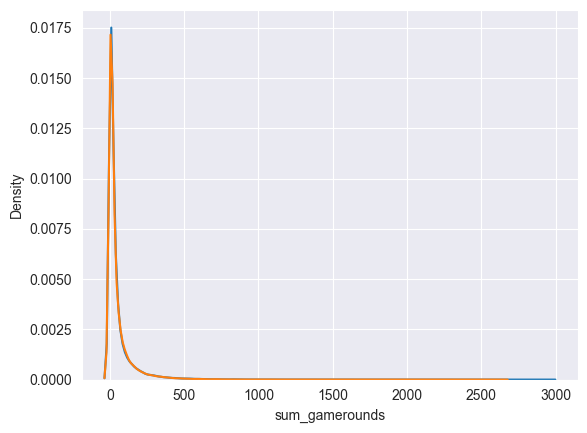

In [29]:
import seaborn as sns
sns.kdeplot(control, label="Control")
sns.kdeplot(treatment, label="Treatment")


The # of Game Rounds played metric is exponentially distributed meaning most values are small, but a few are very large (i.e the distribution has a long right tail).

We can reduce the tail by taking the logged values of # of game rounds played. This should shape our data into a normal distribution which will allow us to use a t-test to compare the logged value between control and treatment.


<Axes: xlabel='sum_gamerounds', ylabel='Density'>

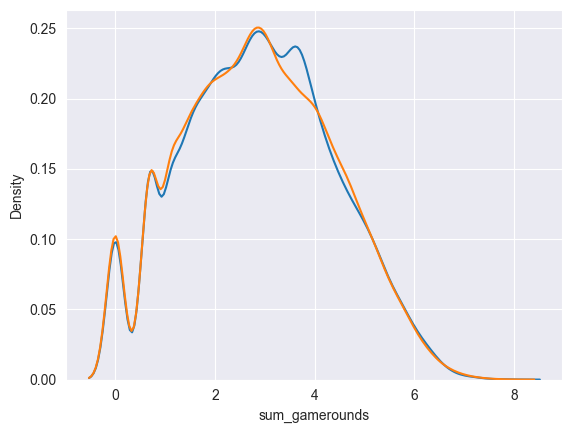

In [30]:
import numpy as np

control_log = np.log1p(control)
treatment_log = np.log1p(treatment)

sns.kdeplot(control_log, label="Control")
sns.kdeplot(treatment_log, label="Treatment")



In [31]:
t_stat, p_value = stats.ttest_ind(treatment_log, control_log, equal_var=False)
print(p_value)

0.07237127222064658


With a p-value of 0.07 we have failed to reject our null hypothesis as the p-value is above our alpha of 0.05

In [32]:
# Confidence Intervals
cm = sms.CompareMeans(sms.DescrStatsW(treatment_log), sms.DescrStatsW(control_log))
conf_int = cm.tconfint_diff(alpha=alpha)  # 95% confidence interval
print(conf_int)


(np.float64(-0.03761775417895695), np.float64(0.001635343611464321))


The mean difference of 0 falls within our confidence interval which should be no surprise as we failed to reject our null hypothesis.